### Optionally install required Python packages (uncomment lines as needed)

In [1]:
# !pip install requests
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly

### Set the URLs of the time-series service endpoints

In [2]:
service_base_url    = 'http://localhost:8001/timeseries-service/api/v1'

status_endpoint     = service_base_url + "/status"
version_endpoint    = service_base_url + "/version"
timeseries_endpoint = service_base_url + "/timeseries"

### Exercise the the status and version endpoints

In [3]:
import requests

In [4]:
print(requests.get(status_endpoint).json())

{'name': 'SKOPE Timeseries Service'}


In [5]:
print(requests.get(version_endpoint).text)

-----------------------------------------------------------------------------
SKOPE Time-Series Service v0.2.0-29 (branch master, commit 7b4fd5c)
-----------------------------------------------------------------------------
Remote repo: https://github.com/openskope/timeseries-service.git
Git branch: master
Last commit: 7b4fd5cbf906e87457cf4a361649f3ecda18859b
Commit time: 2018-05-30T19:14:28-0700
Most recent tag: v0.2.0
Commits since tag: 29
Builder name: Timothy McPhillips
Builder email: tmcphillips@absoluteflow.org
Build host: ulysses-kubuntu
Build platform: Linux 4.15.0-20-generic (amd64)
Build Java VM: OpenJDK 64-Bit Server VM (Oracle Corporation)
Build Java version: JDK 1.8.0_171
Build time: 2018-05-30T19:18:27-0700



### Request the time series at a point in the PaleoCAR dataset

In [6]:
# build the request body
request_json = {  
    "datasetId": "monthly",
    "variableName": "5x5x60_int16",
    "start": '0001-01', 
    "end": '0001-12', 
    "timeResolution": 'monthly', 
    "timeZero": '0001-01', 
    "boundaryGeometry": {
        "type": "Point",
        "coordinates": [-123.0,45.0]
    }
}

# make the post request and store the response
response = requests.post(timeseries_endpoint, json=request_json)

# confirm that the request was successful
assert response.status_code == 200

In [7]:
# get the body of the response as JSON
response_json = response.json()

# confirm that the metadata in the response is as expected
assert response_json['datasetId']    == 'monthly'
assert response_json['variableName'] == '5x5x60_int16'
assert response_json['start']        == '0001-01'
assert response_json['end']          == '0001-12'
assert response_json['startIndex']   == 0
assert response_json['endIndex']     == 11

# confirm that the values list is of the expected size
assert len(response_json['values'])  == 12

### Load response csv property into a Pandas dataframe

In [8]:
import pandas as pd
from io import StringIO

csv = StringIO(response_json['csv'])
df = pd.read_csv(csv)
print(df)

      month   5x5x60_int16
0   0001-01            100
1   0001-02            200
2   0001-03            300
3   0001-04            400
4   0001-05            500
5   0001-06            600
6   0001-07            700
7   0001-08            800
8   0001-09            900
9   0001-10           1000
10  0001-11           1100
11  0001-12           1200


### Pretty-print ten points in time series as a table

In [9]:
from IPython.display import display, HTML
display(HTML(df.to_html(index=False)))

month,5x5x60_int16
0001-01,100
0001-02,200
0001-03,300
0001-04,400
0001-05,500
0001-06,600
0001-07,700
0001-08,800
0001-09,900
0001-10,1000


### Create a static plot of the time series using Matplotlib

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
timeseries_values = response_json['values']

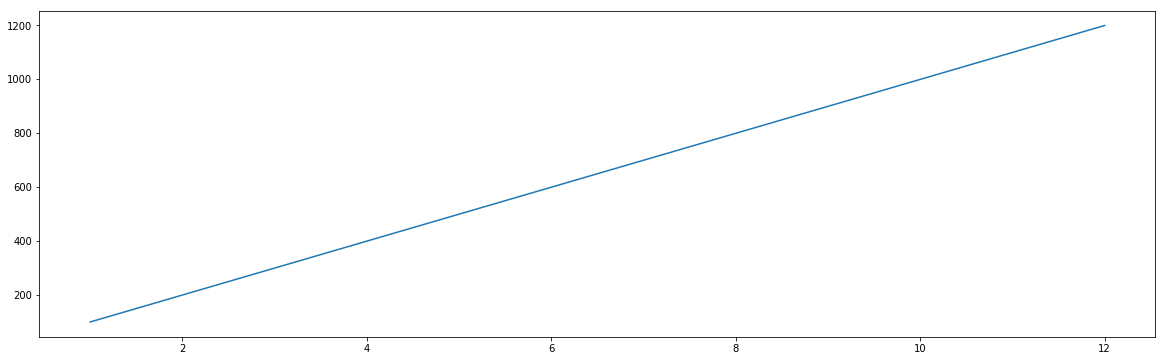

In [12]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
p = ax.plot(range(1,13), timeseries_values[:])
#ax.set_title("Reconstructed growing degree days at (-106.0,41.0)")
#ax.set_xlabel("Year")
#ax.set_ylabel("GDD")
#ax.set_xlim(1,12)
#ax.set_xticks([1] + list(plt.xticks()[0][1:-1]) + [2000]);
#ax.grid(True)

### Create an interactive plot with range slider using Plotly

In [13]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(rangeselector=dict(), rangeslider=dict())
)

fig = dict(
    data=[{"x":list(range(1,2001)), "y": timeseries_values[:2000]}], 
    layout=layout
)

iplot(fig)